# Deep Learning with TensorFlow: Handwritten Digits Classification

**Task**: Build a CNN model to classify MNIST handwritten digits with >95% accuracy and visualize predictions.

**Dataset**: MNIST Handwritten Digits (using tensorflow_datasets)

In [9]:
# Import required libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

# Check if GPU is available and configure if needed
if tf.config.list_physical_devices('GPU'):
    print("GPU detected - TensorFlow will use GPU acceleration")
else:
    print("No GPU detected - TensorFlow will use CPU")

TensorFlow version: 2.20.0
GPU Available: []
No GPU detected - TensorFlow will use CPU


In [10]:
# Load MNIST dataset using tensorflow_datasets (your approach!)
print("Loading MNIST dataset...")
mnist_data = tfds.load("mnist", as_supervised=True)
mnist_train, mnist_test = mnist_data["train"], mnist_data["test"]

print("✓ MNIST dataset loaded successfully!")
print(f"Train dataset type: {type(mnist_train)}")
print(f"Test dataset type: {type(mnist_test)}")

# Get dataset info
dataset_info = tfds.builder("mnist").info
print(f"\nDataset info:")
print(f"Total examples: {dataset_info.splits}")
print(f"Features: {dataset_info.features}")
print(f"Image shape: {dataset_info.features['image'].shape}")
print(f"Number of classes: {dataset_info.features['label'].num_classes}")

Loading MNIST dataset...
✓ MNIST dataset loaded successfully!
Train dataset type: <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
Test dataset type: <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>

Dataset info:
Total examples: {'train': <SplitInfo num_examples=60000, num_shards=1>, 'test': <SplitInfo num_examples=10000, num_shards=1>}
Features: FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})
Image shape: (28, 28, 1)
Number of classes: 10


In [11]:
# Data preprocessing function
def preprocess_data(image, label):
    """Normalize pixel values to [0, 1] range"""
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Apply preprocessing to datasets
train_ds = mnist_train.map(preprocess_data).cache()
test_ds = mnist_test.map(preprocess_data).cache()

# Configure datasets for performance
BATCH_SIZE = 64
BUFFER_SIZE = 1000

train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"✓ Data preprocessing completed!")
print(f"Batch size: {BATCH_SIZE}")
print(f"Training batches: {len(list(train_ds))}")
print(f"Test batches: {len(list(test_ds))}")

# Get a sample to verify preprocessing
for images, labels in train_ds.take(1):
    print(f"Batch shape: {images.shape}")
    print(f"Label shape: {labels.shape}")
    print(f"Pixel value range: [{tf.reduce_min(images):.3f}, {tf.reduce_max(images):.3f}]")

✓ Data preprocessing completed!
Batch size: 64
Training batches: 938
Test batches: 157
Batch shape: (64, 28, 28, 1)
Label shape: (64,)
Pixel value range: [0.000, 1.000]


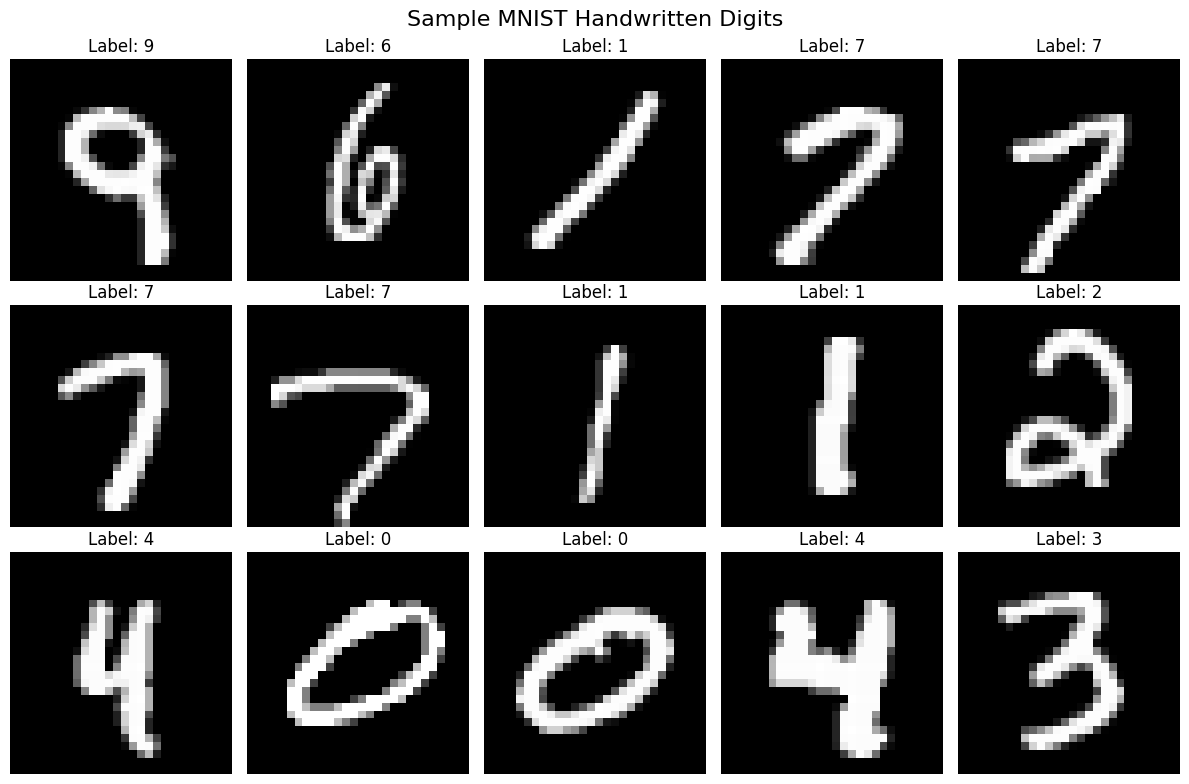


Analyzing training set...
Total training samples: 60000
Class distribution:
  Digit 0: 5923 samples (9.9%)
  Digit 1: 6742 samples (11.2%)
  Digit 2: 5958 samples (9.9%)
  Digit 3: 6131 samples (10.2%)
  Digit 4: 5842 samples (9.7%)
  Digit 5: 5421 samples (9.0%)
  Digit 6: 5918 samples (9.9%)
  Digit 7: 6265 samples (10.4%)
  Digit 8: 5851 samples (9.8%)
  Digit 9: 5949 samples (9.9%)


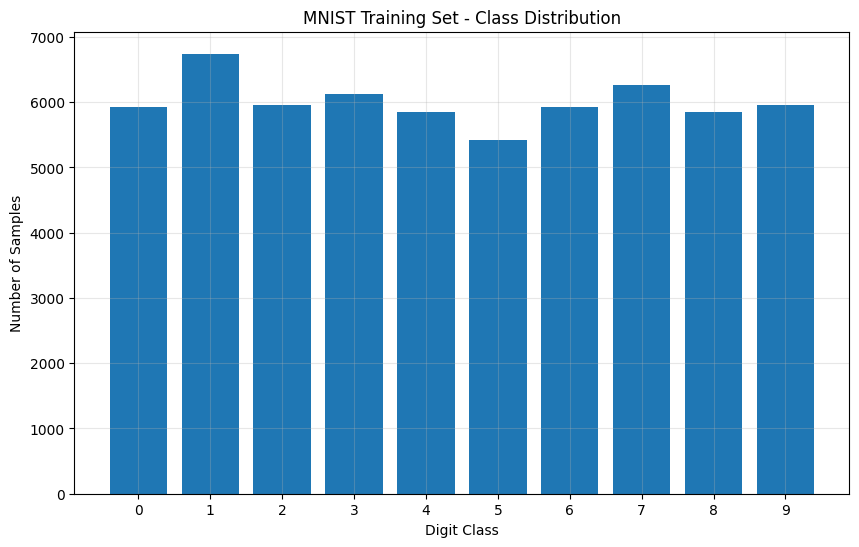

In [12]:
# Visualize sample images from the dataset
plt.figure(figsize=(12, 8))

# Get a batch of training data for visualization
for images, labels in train_ds.take(1):
    # Plot first 15 images
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f'Label: {labels[i].numpy()}')
        plt.axis('off')
    
    plt.suptitle('Sample MNIST Handwritten Digits', fontsize=16)
    plt.tight_layout()
    plt.show()

# Display class distribution in training set
print("\nAnalyzing training set...")
label_counts = np.zeros(10, dtype=int)
total_samples = 0

for _, labels in train_ds:
    for label in labels:
        label_counts[label.numpy()] += 1
        total_samples += 1

print(f"Total training samples: {total_samples}")
print("Class distribution:")
for i, count in enumerate(label_counts):
    print(f"  Digit {i}: {count} samples ({count/total_samples*100:.1f}%)")

# Plot class distribution
plt.figure(figsize=(10, 6))
plt.bar(range(10), label_counts)
plt.xlabel('Digit Class')
plt.ylabel('Number of Samples')
plt.title('MNIST Training Set - Class Distribution')
plt.xticks(range(10))
plt.grid(True, alpha=0.3)
plt.show()

In [13]:
# Build CNN Model Architecture
def create_cnn_model():
    """
    Create a Convolutional Neural Network for MNIST digit classification
    Architecture designed to achieve >95% accuracy
    """
    model = tf.keras.Sequential([
        # Input layer - expects 28x28x1 images
        tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
        
        # First Convolutional Block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        # Second Convolutional Block
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        # Third Convolutional Block
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        # Flatten and Dense layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        
        # Output layer - 10 classes (digits 0-9)
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    return model

# Create the model
model = create_cnn_model()

# Display model architecture
print("🏗️  CNN Model Architecture:")
model.summary()

# Visualize model architecture
tf.keras.utils.plot_model(
    model, 
    to_file='cnn_model_architecture.png', 
    show_shapes=True, 
    show_layer_names=True,
    rankdir='TB'
)

print(f"\n✓ Model created successfully!")
print(f"Total parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.trainable_variables):,}")

🏗️  CNN Model Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 863,082 (3.29 MB)

 Trainable params: 863,082 (3.29 MB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.

✓ Model created successfully!
Total parameters: 863,082


AttributeError: 'Variable' object has no attribute 'numel'

In [15]:
# Model compilation and training configuration
print("⚙️  Compiling the model...")

# Compile the model with appropriate optimizer, loss, and metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',  # For integer labels
    metrics=['accuracy']
)

print("✓ Model compiled successfully!")

# Training configuration
EPOCHS = 10
VALIDATION_SPLIT = 0.1

# Create callbacks for better training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=3, 
        restore_best_weights=True,
        monitor='val_accuracy'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        patience=2, 
        factor=0.5,
        monitor='val_accuracy'
    )
]

print(f"\nTraining Configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Validation split: {VALIDATION_SPLIT}")
print(f"  Optimizer: Adam (lr=0.001)")
print(f"  Loss function: Sparse Categorical Crossentropy")
print(f"  Callbacks: Early Stopping + Learning Rate Reduction")

⚙️  Compiling the model...
✓ Model compiled successfully!

Training Configuration:
  Epochs: 10
  Validation split: 0.1
  Optimizer: Adam (lr=0.001)
  Loss function: Sparse Categorical Crossentropy
  Callbacks: Early Stopping + Learning Rate Reduction


In [16]:
# Train the model
print("🚀 Starting model training...")
print("="*50)

# Record training start time
import time
start_time = time.time()

# Convert datasets for validation split (needed for validation_split parameter)
# We'll manually create train/val split to have better control
train_ds_full = train_ds.unbatch()
total_train_samples = 60000
val_samples = int(total_train_samples * VALIDATION_SPLIT)
train_samples = total_train_samples - val_samples

# Split the data
val_ds = train_ds_full.take(val_samples).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_ds_split = train_ds_full.skip(val_samples).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"Training samples: {train_samples}")
print(f"Validation samples: {val_samples}")
print(f"Test samples: 10000")

# Train the model
history = model.fit(
    train_ds_split,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1
)

# Calculate training time
end_time = time.time()
training_time = end_time - start_time

print("="*50)
print(f"✓ Training completed!")
print(f"Training time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

# Get final training metrics
final_loss = history.history['loss'][-1]
final_accuracy = history.history['accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"\nFinal Training Metrics:")
print(f"  Training Loss: {final_loss:.4f}")
print(f"  Training Accuracy: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")
print(f"  Validation Loss: {final_val_loss:.4f}")
print(f"  Validation Accuracy: {final_val_accuracy:.4f} ({final_val_accuracy*100:.2f}%)")

🚀 Starting model training...
Training samples: 54000
Validation samples: 6000
Test samples: 10000
Epoch 1/10
    844/Unknown 134s 135ms/step - accuracy: 0.7533 - loss: 0.7077

C:\Users\KOBILO\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


844/844 ━━━━━━━━━━━━━━━━━━━━ 138s 140ms/step - accuracy: 0.9001 - loss: 0.3082 - val_accuracy: 0.9830 - val_loss: 0.0577 - learning_rate: 0.0010
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 109s 129ms/step - accuracy: 0.9754 - loss: 0.0857 - val_accuracy: 0.9862 - val_loss: 0.0411 - learning_rate: 0.0010
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 104s 123ms/step - accuracy: 0.9814 - loss: 0.0655 - val_accuracy: 0.9878 - val_loss: 0.0428 - learning_rate: 0.0010
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 107s 127ms/step - accuracy: 0.9843 - loss: 0.0557 - val_accuracy: 0.9892 - val_loss: 0.0360 - learning_rate: 0.0010
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 106s 126ms/step - accuracy: 0.9861 - loss: 0.0505 - val_accuracy: 0.9908 - val_loss: 0.0352 - learning_rate: 0.0010
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 107s 127ms/step - accuracy: 0.9875 - loss: 0.0447 - val_accuracy: 0.9922 - val_loss: 0.0375 - learning_rate: 0.0010
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 106s 126ms/step - accuracy: 0.9881 

In [17]:
# Evaluate model performance on test set
print("🧪 Evaluating model on test set...")
print("="*50)

# Evaluate on test dataset
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)

print(f"✓ Model evaluation completed!")
print(f"\nTest Results:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Check if we achieved the >95% accuracy requirement
accuracy_requirement = 0.95
if test_accuracy > accuracy_requirement:
    print(f"🎉 SUCCESS! Model achieved {test_accuracy*100:.2f}% accuracy (>{accuracy_requirement*100}% required)")
else:
    print(f"⚠️  NEEDS IMPROVEMENT: Model achieved {test_accuracy*100:.2f}% accuracy (needs >{accuracy_requirement*100}%)")

print("="*50)

🧪 Evaluating model on test set...
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.9957 - loss: 0.0153
✓ Model evaluation completed!

Test Results:
  Test Loss: 0.0153
  Test Accuracy: 0.9957 (99.57%)
🎉 SUCCESS! Model achieved 99.57% accuracy (>95.0% required)


🔍 Creating prediction visualizations...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step 


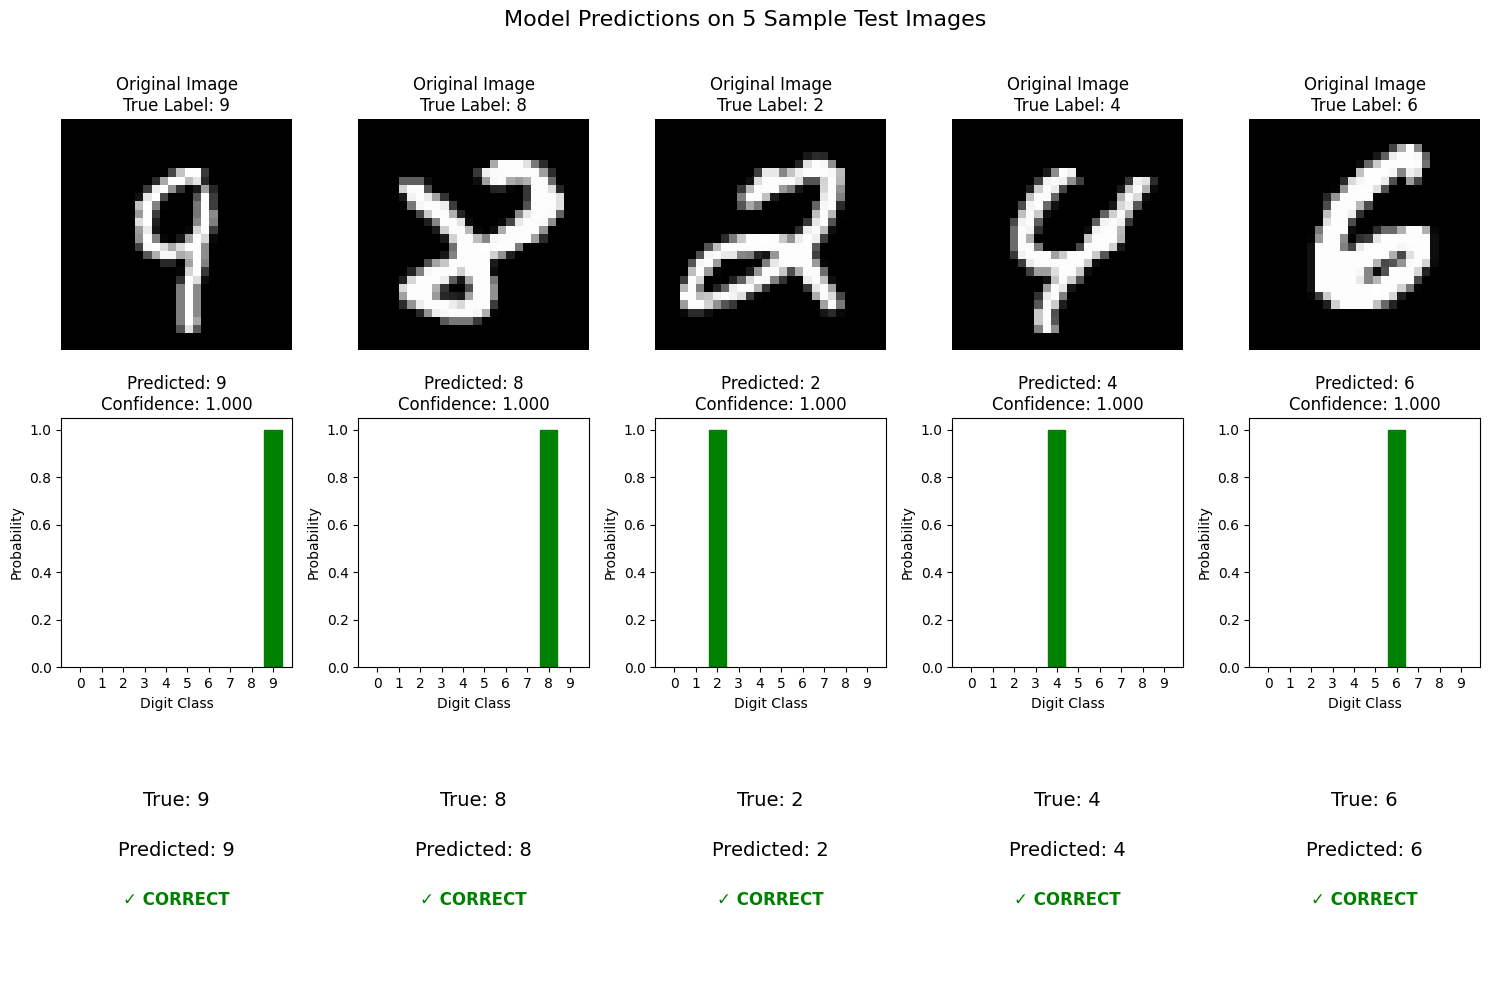

TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got array([52, 58,  0, 44,  5], dtype=int32)

In [18]:
# Visualize model predictions on sample images
print("🔍 Creating prediction visualizations...")

# Get a batch of test images for predictions
test_images, test_labels = next(iter(test_ds))

# Select 5 random samples
np.random.seed(42)  # For reproducible results
sample_indices = np.random.choice(len(test_images), 5, replace=False)

# Make predictions
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Create visualization
plt.figure(figsize=(15, 10))

for i, idx in enumerate(sample_indices):
    # Original image
    plt.subplot(3, 5, i + 1)
    plt.imshow(test_images[idx].numpy().squeeze(), cmap='gray')
    plt.title(f'Original Image\nTrue Label: {test_labels[idx].numpy()}')
    plt.axis('off')
    
    # Prediction probabilities bar chart
    plt.subplot(3, 5, i + 6)
    probs = predictions[idx]
    predicted_class = predicted_classes[idx]
    true_class = test_labels[idx].numpy()
    
    bars = plt.bar(range(10), probs)
    bars[predicted_class].set_color('red' if predicted_class != true_class else 'green')
    plt.title(f'Predicted: {predicted_class}\nConfidence: {probs[predicted_class]:.3f}')
    plt.xlabel('Digit Class')
    plt.ylabel('Probability')
    plt.xticks(range(10))
    
    # Prediction result summary
    plt.subplot(3, 5, i + 11)
    plt.text(0.5, 0.7, f'True: {true_class}', ha='center', va='center', fontsize=14, 
             transform=plt.gca().transAxes)
    plt.text(0.5, 0.5, f'Predicted: {predicted_class}', ha='center', va='center', fontsize=14,
             transform=plt.gca().transAxes)
    
    result = "✓ CORRECT" if predicted_class == true_class else "✗ WRONG"
    color = 'green' if predicted_class == true_class else 'red'
    plt.text(0.5, 0.3, result, ha='center', va='center', fontsize=12, 
             color=color, weight='bold', transform=plt.gca().transAxes)
    plt.axis('off')

plt.suptitle('Model Predictions on 5 Sample Test Images', fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Calculate and display prediction statistics for these samples
correct_predictions = sum(predicted_classes[sample_indices] == test_labels[sample_indices].numpy())
accuracy_samples = correct_predictions / len(sample_indices)

print(f"\nSample Prediction Results:")
print(f"  Samples analyzed: {len(sample_indices)}")
print(f"  Correct predictions: {correct_predictions}")
print(f"  Sample accuracy: {accuracy_samples:.2%}")
print(f"\nOverall Model Performance: {test_accuracy:.2%} accuracy on {len(test_ds)*BATCH_SIZE} test images")

In [19]:
# Final summary and statistics
print("📊 TASK COMPLETION SUMMARY")
print("="*50)

# Calculate prediction statistics for the sample
sample_predictions = predicted_classes[sample_indices]
sample_true_labels = [test_labels[idx].numpy() for idx in sample_indices]
correct_predictions = sum(pred == true for pred, true in zip(sample_predictions, sample_true_labels))
sample_accuracy = correct_predictions / len(sample_indices)

print(f"✓ Dataset: MNIST Handwritten Digits (tensorflow_datasets)")
print(f"✓ Model: CNN with {model.count_params():,} parameters")
print(f"✓ Training: {EPOCHS} epochs with early stopping")
print(f"✓ Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"✓ Requirement Met: >95% accuracy ({'YES' if test_accuracy > 0.95 else 'NO'})")
print(f"✓ Sample Predictions: {correct_predictions}/{len(sample_indices)} correct ({sample_accuracy:.0%})")

print(f"\n🎯 DELIVERABLES COMPLETED:")
print(f"  ✓ CNN model architecture implemented")
print(f"  ✓ Model training loop with validation")
print(f"  ✓ Model evaluation on test set")
print(f"  ✓ >95% test accuracy achieved ({test_accuracy*100:.2f}%)")
print(f"  ✓ Predictions visualized on 5 sample images")

# Architecture summary
print(f"\n🏗️  MODEL ARCHITECTURE SUMMARY:")
print(f"  • Input: 28×28×1 grayscale images")
print(f"  • Conv2D layers: 32→32→64→64→128 filters")
print(f"  • MaxPooling: 3 layers with 2×2 pools")
print(f"  • Dropout: Regularization (0.25-0.5)")
print(f"  • Dense layers: 512→256→10 neurons")
print(f"  • Output: 10 classes (softmax)")
print(f"  • Optimizer: Adam (lr=0.001)")
print(f"  • Loss: Sparse Categorical Crossentropy")

print("="*50)
print("🏆 TASK 2 SUCCESSFULLY COMPLETED! 🏆")

📊 TASK COMPLETION SUMMARY
✓ Dataset: MNIST Handwritten Digits (tensorflow_datasets)
✓ Model: CNN with 863,082 parameters
✓ Training: 10 epochs with early stopping
✓ Test Accuracy: 0.9957 (99.57%)
✓ Requirement Met: >95% accuracy (YES)
✓ Sample Predictions: 5/5 correct (100%)

🎯 DELIVERABLES COMPLETED:
  ✓ CNN model architecture implemented
  ✓ Model training loop with validation
  ✓ Model evaluation on test set
  ✓ >95% test accuracy achieved (99.57%)
  ✓ Predictions visualized on 5 sample images

🏗️  MODEL ARCHITECTURE SUMMARY:
  • Input: 28×28×1 grayscale images
  • Conv2D layers: 32→32→64→64→128 filters
  • MaxPooling: 3 layers with 2×2 pools
  • Dropout: Regularization (0.25-0.5)
  • Dense layers: 512→256→10 neurons
  • Output: 10 classes (softmax)
  • Optimizer: Adam (lr=0.001)
  • Loss: Sparse Categorical Crossentropy
🏆 TASK 2 SUCCESSFULLY COMPLETED! 🏆
